### 1. Build multinomial naïve model

#### 1.1 how to train
For Navie Bayes represented as a multinomial event model, to maximize its maxmimum likelihood with Laplace smoothing,

\begin{align*}
\phi_{k|y=1} &= \frac{\sum_{i=1}^{m} \sum_{j=1}^{n_i} \boldsymbol{1} \{ x_j^{(i)} = k \wedge y^{(i)} =1 \} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \} n_i + \left| V \right|} \\
\phi_{k|y=0} &= \frac{\sum_{i=1}^{m} \sum_{j=1}^{n_i} \boldsymbol{1} \{ x_j^{(i)} = k \wedge y^{(i)} =0 \} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 0 \} n_i + \left| V \right|} \\
\phi_{y} &= \frac{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \}}{m}
\end{align*}

#### 1.2 how to predicte

\begin{align*}
p(y=1|x) &= \frac{p(x|y=1)p(y=1)}{p(x)} \\
              &= \frac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1) + p(x|y=0) p(y=0)} \\
              &= \frac{1}{1 + \frac{p(x|y=0) p(y=0)}{p(x|y=1) p(y=1)}} \\
              &= \frac{1}{1 + \mathrm{exp} (\mathrm{log}P(x|y=0) + \mathrm{log}P(y=0) - \mathrm{log}P(x|y=1) - \mathrm{log} P(y=1))}
\end{align*}


#### 1.3 Code
Since the document-word matrix is extremely sparse (has lots of zero entries), we have stored it in our own efficient format to save space. You don’t have to worry about this format.

In [36]:
import numpy as np


def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline() #head line for the file name
    rows, cols = [int(s) for s in fd.readline().strip().split()] #second line for the size
    tokens = fd.readline().strip().split() #third line for TOKENS_LIST
    matrix = np.zeros((rows, cols)) 
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()] #creat an array for each line
        Y.append(nums[0]) #the first item in each array to create a trainCategory
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)


def nb_train(matrix, category):
    state = {}
    vocabulary_size = matrix.shape[1]
    mat1 = matrix[category == 1, :]
    mat0 = matrix[category == 0, :]

    # documentation length, i.e. number of tokens in each document
    mat1_doc_lens = mat1.sum(axis=1)
        
    # yeq1 means "given y equals 1"
    # mat1.sum(axis=0) refers to number of each token in spams
    
    state['phi_yeq1'] = (mat1.sum(axis=0) + 1) / (np.sum(mat1_doc_lens) + vocabulary_size)

    mat0_doc_lens = mat0.sum(axis=1)
    state['phi_yeq0'] = (mat0.sum(axis=0) + 1) / (np.sum(mat0_doc_lens) + vocabulary_size)

    state['phi'] = mat1.shape[0] / (mat1.shape[0] + mat0.shape[0])
    return state


def nb_test(matrix, state):
    output = np.zeros(matrix.shape[0])
    log_phi_yeq1 = np.sum(np.log(state['phi_yeq1']) * matrix, axis=1)
    log_phi_yeq0 = np.sum(np.log(state['phi_yeq0']) * matrix, axis=1)
    phi = state['phi']    

    # see corresponding notebook for equations
    ratio = np.exp(log_phi_yeq0 + np.log(1 - phi) - log_phi_yeq1 - np.log(phi))
    probs = 1 / (1 + ratio)
    output[probs > 0.5] = 1
    return output


def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print(f"Error: {error}")
    return error

### 2. Use the model

In [32]:
import numpy as np

In [33]:
#  Obtain Data
trainMatrix, tokenlist, trainCategory = readMatrix('spam_data/MATRIX.TRAIN')


## Train Data
state = nb_train(trainMatrix, trainCategory)

1. trainMatrix is now a (numTrainDocs x numTokens) matrix. Each row represents a unique document (email).The j-th column of the row $i$ represents the number of times the j-th token appeared in email $i$.  
2. tokenlist is a long string containing the list of all tokens (words). These tokens are easily known by position in the file TOKENS_LIST     
3. trainCategory is a (1 x numTrainDocs) vector containing the true classifications for the documents just read in. The i-th entry gives the correct class for the i-th email (which corresponds to the i-th row in the document word matrix).  
4. Spam documents are indicated as class 1, and non-spam as class 0. Note that for the SVM, you would want to convert these to +1 and -1.  


##### 2.1 Find the 5 tokens that are most indicative of the SPAM class

In [34]:
tokens = np.array(tokenlist)

tokens[np.argsort(state['phi_yeq1'] / state['phi_yeq0'])[::-1]][:5] 

# argsort: Returns the indices that would sort an array
# [::-1] reverse (from the largest to the smallest)
# [:10] selct the first 10 largest

array(['httpaddr', 'spam', 'unsubscrib', 'ebai', 'valet'], dtype='<U16')

##### 2.2 Repeat, but with training sets of size ranging from 50, 100, 200, . . . , up to 1400,

In [49]:
import glob
import matplotlib.pyplot as plt

In [50]:
files = sorted(glob.glob('./spam_data/MATRIX.TRAIN.[0-9]*'), key=lambda s: int(s.rsplit('.')[-1]))

nb_sizes = []
nb_errs = []
mat_test, tok_test, cat_test = readMatrix('./spam_data/MATRIX.TEST')


for f in files:
    mat, tok, cat = readMatrix(f)
    nb_sizes.append(mat.shape[0])
    mod = nb_train(mat, cat)
    output = nb_test(mat_test, mod)
    nb_errs.append(evaluate(output, cat_test))

Error: 0.03875
Error: 0.02625
Error: 0.02625
Error: 0.01875
Error: 0.0175
Error: 0.01625


Text(0, 0.5, 'error')

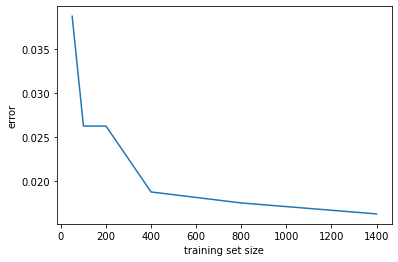

In [52]:
plt.plot(nb_sizes,nb_errs)
plt.xlabel('training set size')
plt.ylabel('error')